### **Importing the necessary Libraries**

In [6]:
# importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

#Importing the models required|
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [7]:
!pip freeze > requirements.txt

In [8]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Dataset/delhi_weather_dataset.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
df.head()

,NAME,DATE,PRCP,TAVG,TMAX,TMIN,WIND_MAX(kph),WIND_MIN(kph),AVG_WIND(kph),HUMIDITY_(%),Weather,Weather_Description,Icon
0,delhi,2013-01-01,0.0,8.9,18.5,5.0,11.9,11.9,5.95,90.3,Partially cloudy,Partly cloudy throughout the day.,fog
1,delhi,2013-01-02,0.0,7.4,16.6,6.0,15.5,15.5,7.75,93.9,Partially cloudy,Partly cloudy throughout the day.,fog
2,delhi,2013-01-03,0.0,7.3,12.3,4.6,13.0,13.0,6.50,93.8,Partially cloudy,Partly cloudy throughout the day.,fog
3,delhi,2013-01-04,0.0,7.1,14.9,3.0,9.6,9.6,4.80,87.3,Partially cloudy,Partly cloudy throughout the day.,fog
4,delhi,2013-01-05,0.0,6.4,11.3,2.6,13.0,13.0,6.50,93.9,Partially cloudy,Clearing in the afternoon.,partly-cloudy-day


### **Pre processing of the Data**

In [10]:
# Removing the unwanted columns as they have repeated values
df.drop(columns=["NAME","Weather_Description","Icon"],inplace=True)


In [11]:
df

,DATE,PRCP,TAVG,TMAX,TMIN,WIND_MAX(kph),WIND_MIN(kph),AVG_WIND(kph),HUMIDITY_(%),Weather
0,2013-01-01,0.0,8.9,18.5,5.0,11.9,11.9,5.95,90.3,Partially cloudy
1,2013-01-02,0.0,7.4,16.6,6.0,15.5,15.5,7.75,93.9,Partially cloudy
2,2013-01-03,0.0,7.3,12.3,4.6,13.0,13.0,6.50,93.8,Partially cloudy
3,2013-01-04,0.0,7.1,14.9,3.0,9.6,9.6,4.80,87.3,Partially cloudy
4,2013-01-05,0.0,6.4,11.3,2.6,13.0,13.0,6.50,93.9,Partially cloudy
...,...,...,...,...,...,...,...,...,...,...
4012,2023-12-27,0.0,13.0,19.5,10.3,11.2,9.4,10.30,91.9,Partially cloudy
4013,2023-12-28,0.0,12.8,19.5,9.3,12.2,9.4,10.80,91.1,Partially cloudy
4014,2023-12-29,0.0,13.8,18.6,12.0,7.9,9.4,8.65,93.9,Partially cloudy
4015,2023-12-30,0.0,14.6,19.4,12.8,6.5,9.4,7.95,90.0,Partially cloudy


In [12]:
# Checking for the missing values
df.isnull().sum()

DATE             0
PRCP             0
TAVG             0
TMAX             0
TMIN             0
WIND_MAX(kph)    0
WIND_MIN(kph)    0
AVG_WIND(kph)    0
HUMIDITY_(%)     0
Weather          0
dtype: int64

In [13]:
# Convert date column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

In [14]:
# Define a function to impute temperature values based on season
def impute_temp(row):
    # Check if the temperature value is missing
    if pd.isnull(row['TMAX']) or pd.isnull(row['TMIN']):
        # Define temperature ranges for different seasons
        summer_max = 32
        summer_min = 26
        rainy_max = 31.9
        rainy_min = 25.8
        winter_max = 30
        winter_min = 18

        # Get the month of the current row
        month = row['DATE'].month

        # Impute temperature values based on the season
        if month in [2, 3, 4, 5]:
            # Spring/Fall Season
            row['TMAX'] = (row['TMAX'] + summer_max) / 2 if pd.notnull(row['TMAX']) else summer_max
            row['TMIN'] = (row['TMIN'] + summer_min) / 2 if pd.notnull(row['TMIN']) else summer_min
        elif month in [6, 7, 8, 9]:
            # Rainy Season
            row['TMAX'] = (row['TMAX'] + rainy_max) / 2 if pd.notnull(row['TMAX']) else rainy_max
            row['TMIN'] = (row['TMIN'] + rainy_min) / 2 if pd.notnull(row['TMIN']) else rainy_min
        else:
            # Winter Season
            row['TMAX'] = (row['TMAX'] + winter_max) / 2 if pd.notnull(row['TMAX']) else winter_max
            row['TMIN'] = (row['TMIN'] + winter_min) / 2 if pd.notnull(row['TMIN']) else winter_min

        # Add a small random value to the imputed temperature values
        row['TMAX'] += np.random.uniform(low=0.01, high=0.99)
        row['TMIN'] += np.random.uniform(low=0.01, high=0.99)

    return row

# Impute temperature values using the impute_temp function
df_imputed = df.apply(impute_temp, axis=1)

# Round off the temperature values to 2 decimal places
df_imputed['TMAX'] = df_imputed['TMAX'].round(2)
df_imputed['TMIN'] = df_imputed['TMIN'].round(2)

# Print the first 5 rows of the imputed dataframe
df_imputed


,DATE,PRCP,TAVG,TMAX,TMIN,WIND_MAX(kph),WIND_MIN(kph),AVG_WIND(kph),HUMIDITY_(%),Weather
0,2013-01-01,0.0,8.9,18.5,5.0,11.9,11.9,5.95,90.3,Partially cloudy
1,2013-01-02,0.0,7.4,16.6,6.0,15.5,15.5,7.75,93.9,Partially cloudy
2,2013-01-03,0.0,7.3,12.3,4.6,13.0,13.0,6.50,93.8,Partially cloudy
3,2013-01-04,0.0,7.1,14.9,3.0,9.6,9.6,4.80,87.3,Partially cloudy
4,2013-01-05,0.0,6.4,11.3,2.6,13.0,13.0,6.50,93.9,Partially cloudy
...,...,...,...,...,...,...,...,...,...,...
4012,2023-12-27,0.0,13.0,19.5,10.3,11.2,9.4,10.30,91.9,Partially cloudy
4013,2023-12-28,0.0,12.8,19.5,9.3,12.2,9.4,10.80,91.1,Partially cloudy
4014,2023-12-29,0.0,13.8,18.6,12.0,7.9,9.4,8.65,93.9,Partially cloudy
4015,2023-12-30,0.0,14.6,19.4,12.8,6.5,9.4,7.95,90.0,Partially cloudy


In [15]:
df_imputed.isnull().sum()

DATE             0
PRCP             0
TAVG             0
TMAX             0
TMIN             0
WIND_MAX(kph)    0
WIND_MIN(kph)    0
AVG_WIND(kph)    0
HUMIDITY_(%)     0
Weather          0
dtype: int64

In [16]:
df_imputed.Weather.value_counts()

Weather
Clear                     1571
Partially cloudy          1526
Rain, Partially cloudy     823
Rain, Cloudy                84
Rain                        12
Cloudy                       1
Name: count, dtype: int64

In [17]:
# Convert date column to datetime format
df_imputed['DATE'] = pd.to_datetime(df_imputed['DATE'])

# Set the 'DATE' column as the index
df_imputed.set_index('DATE', inplace=True)

# Print the updated DataFrame
df_imputed

,PRCP,TAVG,TMAX,TMIN,WIND_MAX(kph),WIND_MIN(kph),AVG_WIND(kph),HUMIDITY_(%),Weather
DATE,,,,,,,,,
2013-01-01,0.0,8.9,18.5,5.0,11.9,11.9,5.95,90.3,Partially cloudy
2013-01-02,0.0,7.4,16.6,6.0,15.5,15.5,7.75,93.9,Partially cloudy
2013-01-03,0.0,7.3,12.3,4.6,13.0,13.0,6.50,93.8,Partially cloudy
2013-01-04,0.0,7.1,14.9,3.0,9.6,9.6,4.80,87.3,Partially cloudy
2013-01-05,0.0,6.4,11.3,2.6,13.0,13.0,6.50,93.9,Partially cloudy
...,...,...,...,...,...,...,...,...,...
2023-12-27,0.0,13.0,19.5,10.3,11.2,9.4,10.30,91.9,Partially cloudy
2023-12-28,0.0,12.8,19.5,9.3,12.2,9.4,10.80,91.1,Partially cloudy
2023-12-29,0.0,13.8,18.6,12.0,7.9,9.4,8.65,93.9,Partially cloudy


In [18]:
df_imputed.to_csv("EDA_data.csv")

### **Exploratory Data Analysis**

In [19]:
df = pd.read_csv("EDA_data.csv")

#### **Scatterplot of the Temperature columns**

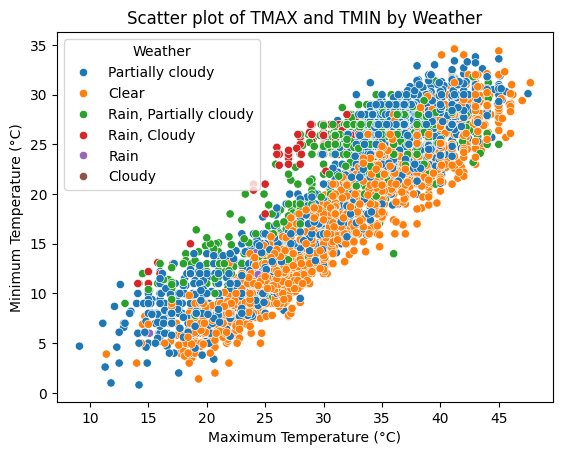

In [20]:
sns.scatterplot(x='TMAX', y='TMIN', hue='Weather', data=df)
plt.xlabel('Maximum Temperature (°C)')
plt.ylabel('Minimum Temperature (°C)')
plt.title('Scatter plot of TMAX and TMIN by Weather')
plt.show()

<h3><b>Observations of the Scatterplot TMAX and TMIN</b></h3>
<p>The scatterplot of TMAX (maximum temperature) and TMIN (minimum temperature) by weather type shows the following observations:</p>
<ol>
  <li>There is a strong positive correlation between maximum and minimum temperature, which is expected as they are both measures of temperature.</li>
  <li>The data points are clustered around a diagonal line, which indicates that when the maximum temperature is high, the minimum temperature is also high, and vice versa.</li>
  <li>The plot shows that the data points are grouped by weather type, with different colors representing different weather conditions.</li>
  <li>There is some overlap in temperature ranges between different weather types, suggesting that some weather conditions may have similar temperature ranges.</li>
</ol>
<p>Overall, this scatterplot provides a clear visualization of the relationship between maximum and minimum temperature, and how they vary across different weather conditions.</p>

#### **Scatterplot of the Wind speed columns**

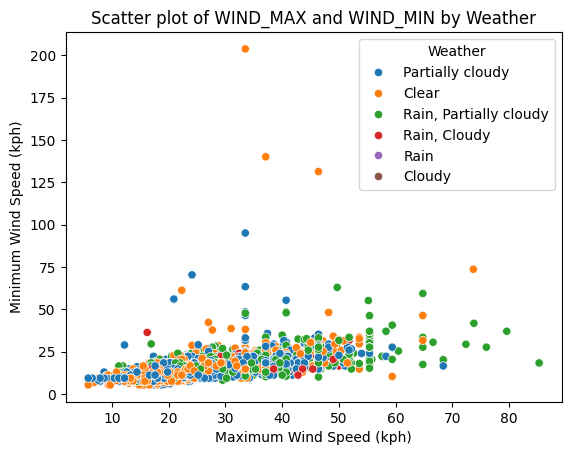

In [21]:
sns.scatterplot(x='WIND_MAX(kph)', y='WIND_MIN(kph)', hue='Weather', data=df)
plt.xlabel('Maximum Wind Speed (kph)')
plt.ylabel('Minimum Wind Speed (kph)')
plt.title('Scatter plot of WIND_MAX and WIND_MIN by Weather')
plt.show()

<h3><b>Observations of the Scatterplot WIND_MAX(kph) and WIND_MIN(kph)</b></h3>
<p>The scatterplot of WIND_MAX(kph) (maximum windspeed) and WIND_MIN (minimum windspeed) by weather type shows the following observations:</p>
<ol>
  <li>There is a strong positive correlation between maximum and minimum windspeed, which is expected as they are both measures of temperature.</li>
  <li>The data points are clustered into four separate groups, which indicates, different range of wind speeds for different conditions.</li>
  <li>The plot shows that the wind speed is greater during harsh weather conditions of rains and thunderstorms and comparatively lesser during sunny and cloudy weather</li>
  <li>There is some overlap in temperature ranges between different weather types, suggesting that some weather conditions may have similar temperature ranges.</li>
</ol>
<p>Overall, this scatterplot provides a clear visualization of the relationship between maximum and minimum windspeed, and how they vary across different weather conditions.</p>

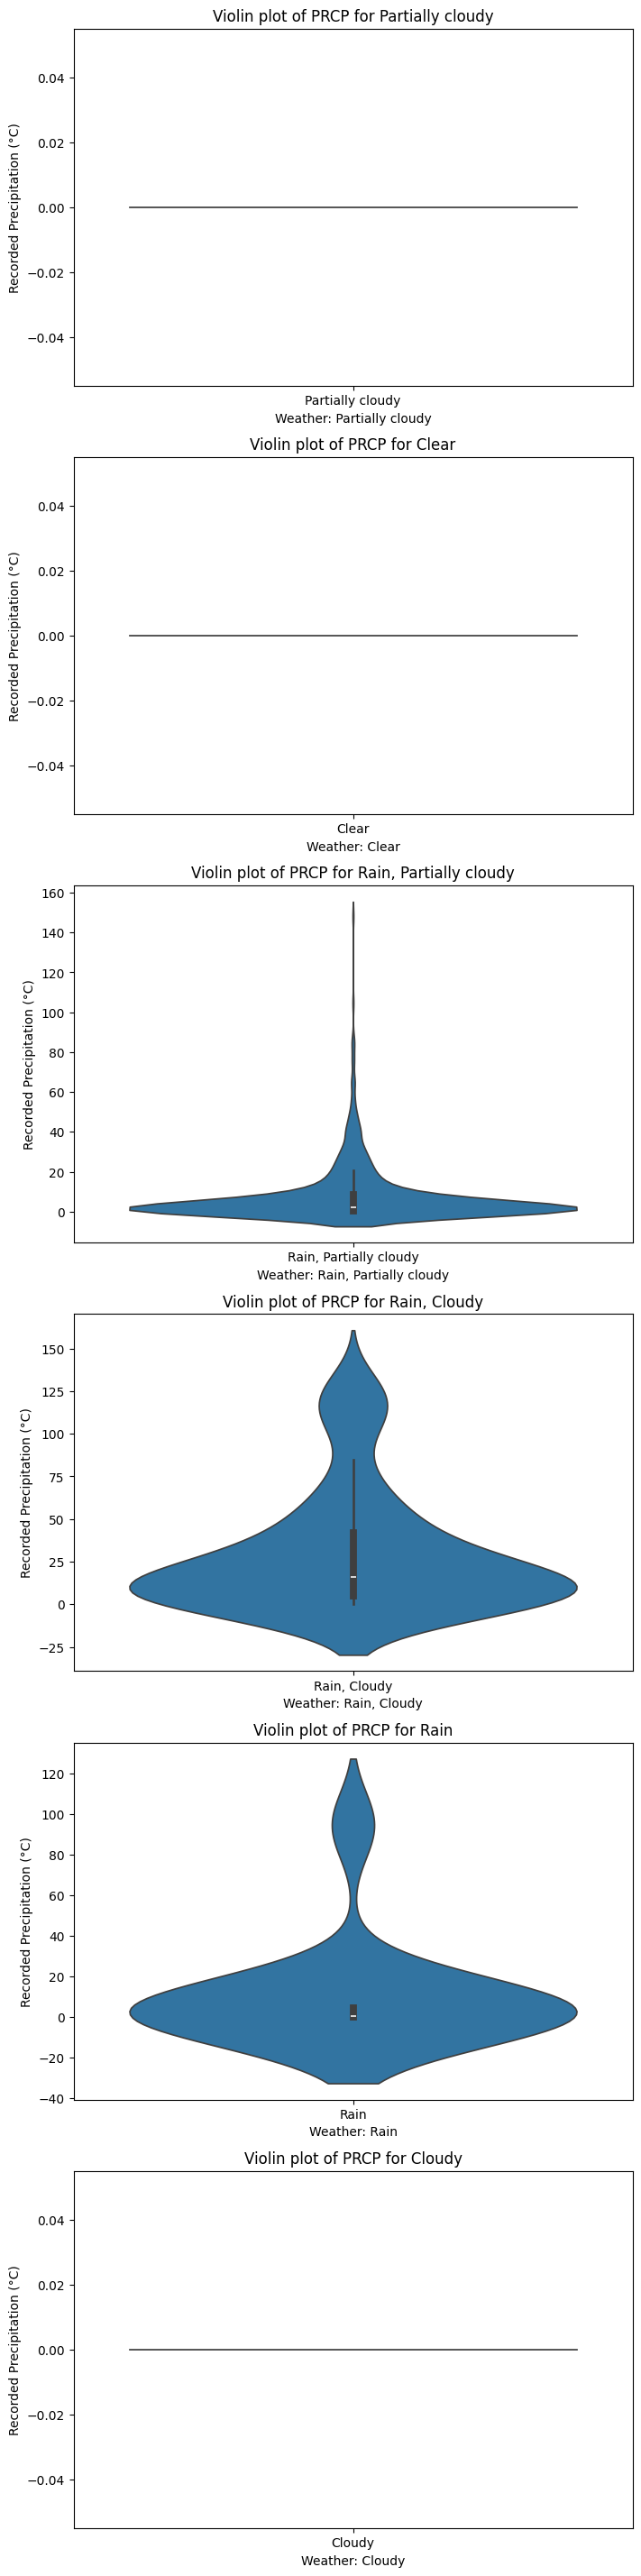

In [22]:
# Get unique categories in "Weather" column
weather_categories = df['Weather'].unique()

# Set up subplots
fig, axes = plt.subplots(nrows=len(weather_categories), figsize=(8, 6*len(weather_categories)))

# Loop over categories and create violin plots
for i, weather in enumerate(weather_categories):
    # Subset data for current category
    subset_df = df[df['Weather'] == weather]

    # Create violin plot
    sns.violinplot(x='Weather', y='PRCP', data=subset_df, ax=axes[i])

    # Set axis labels and title
    axes[i].set_xlabel('Weather: {}'.format(weather))
    axes[i].set_ylabel('Recorded Precipitation (°C)')
    axes[i].set_title('Violin plot of PRCP for {}'.format(weather))

# Show plots
plt.show()

<h3><b>Observations from the Violin Plot</b></h3>
<p>Based on the violin plot, the following observations can be made:</p>
<ul>
<li>The Rainy category has a wide range of precipitation amounts, from light drizzles to heavy downpours.</li>
<li>The Sunny and Cloudy categories have a narrower distribution, indicating less variability in recorded precipitation.</li>
<li>The Thunderstorm category has higher precipitation values than other categories, suggesting heavier rainfall on average.</li>
</ul>

#### **Trend of temperature with time**

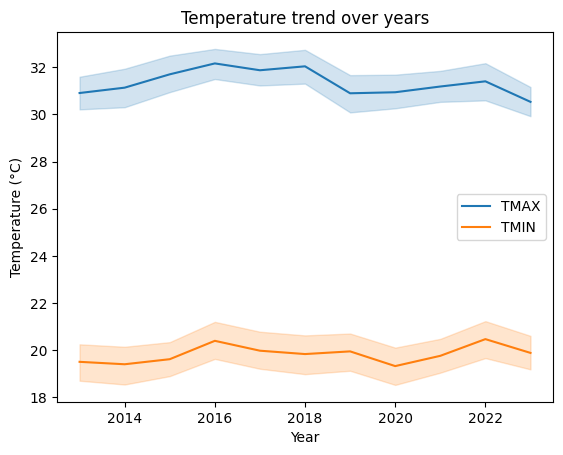

In [23]:
# set date column as datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# extract year from date
df['YEAR'] = df['DATE'].dt.year

# plot line plot of temperature against year
sns.lineplot(x='YEAR', y='TMAX', data=df, label='TMAX')
sns.lineplot(x='YEAR', y='TMIN', data=df, label='TMIN')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Temperature trend over years')
plt.show()

<h3><b>Trend of temperature with time</b></h3>
<ul>
    <li>The maximum and minimum temperature have both increased over the years, suggesting a general warming trend.</li>
    <li>The increase in minimum temperature appears to be steeper than the increase in maxium temperature.</li>
    <li>There is some variability in temperature from year to year, but overall, the trend towards warmer temperatures is consistent.</li>
    <li>There are some dips in temperature in the early 2010s and late 2010s, but the overall trend is still upwards.</li>
    <li>The temperature range between the maximum and minimum temperature appears to be consistent over the years.</li>
</ul>

#### **Pairplot of the dataset**

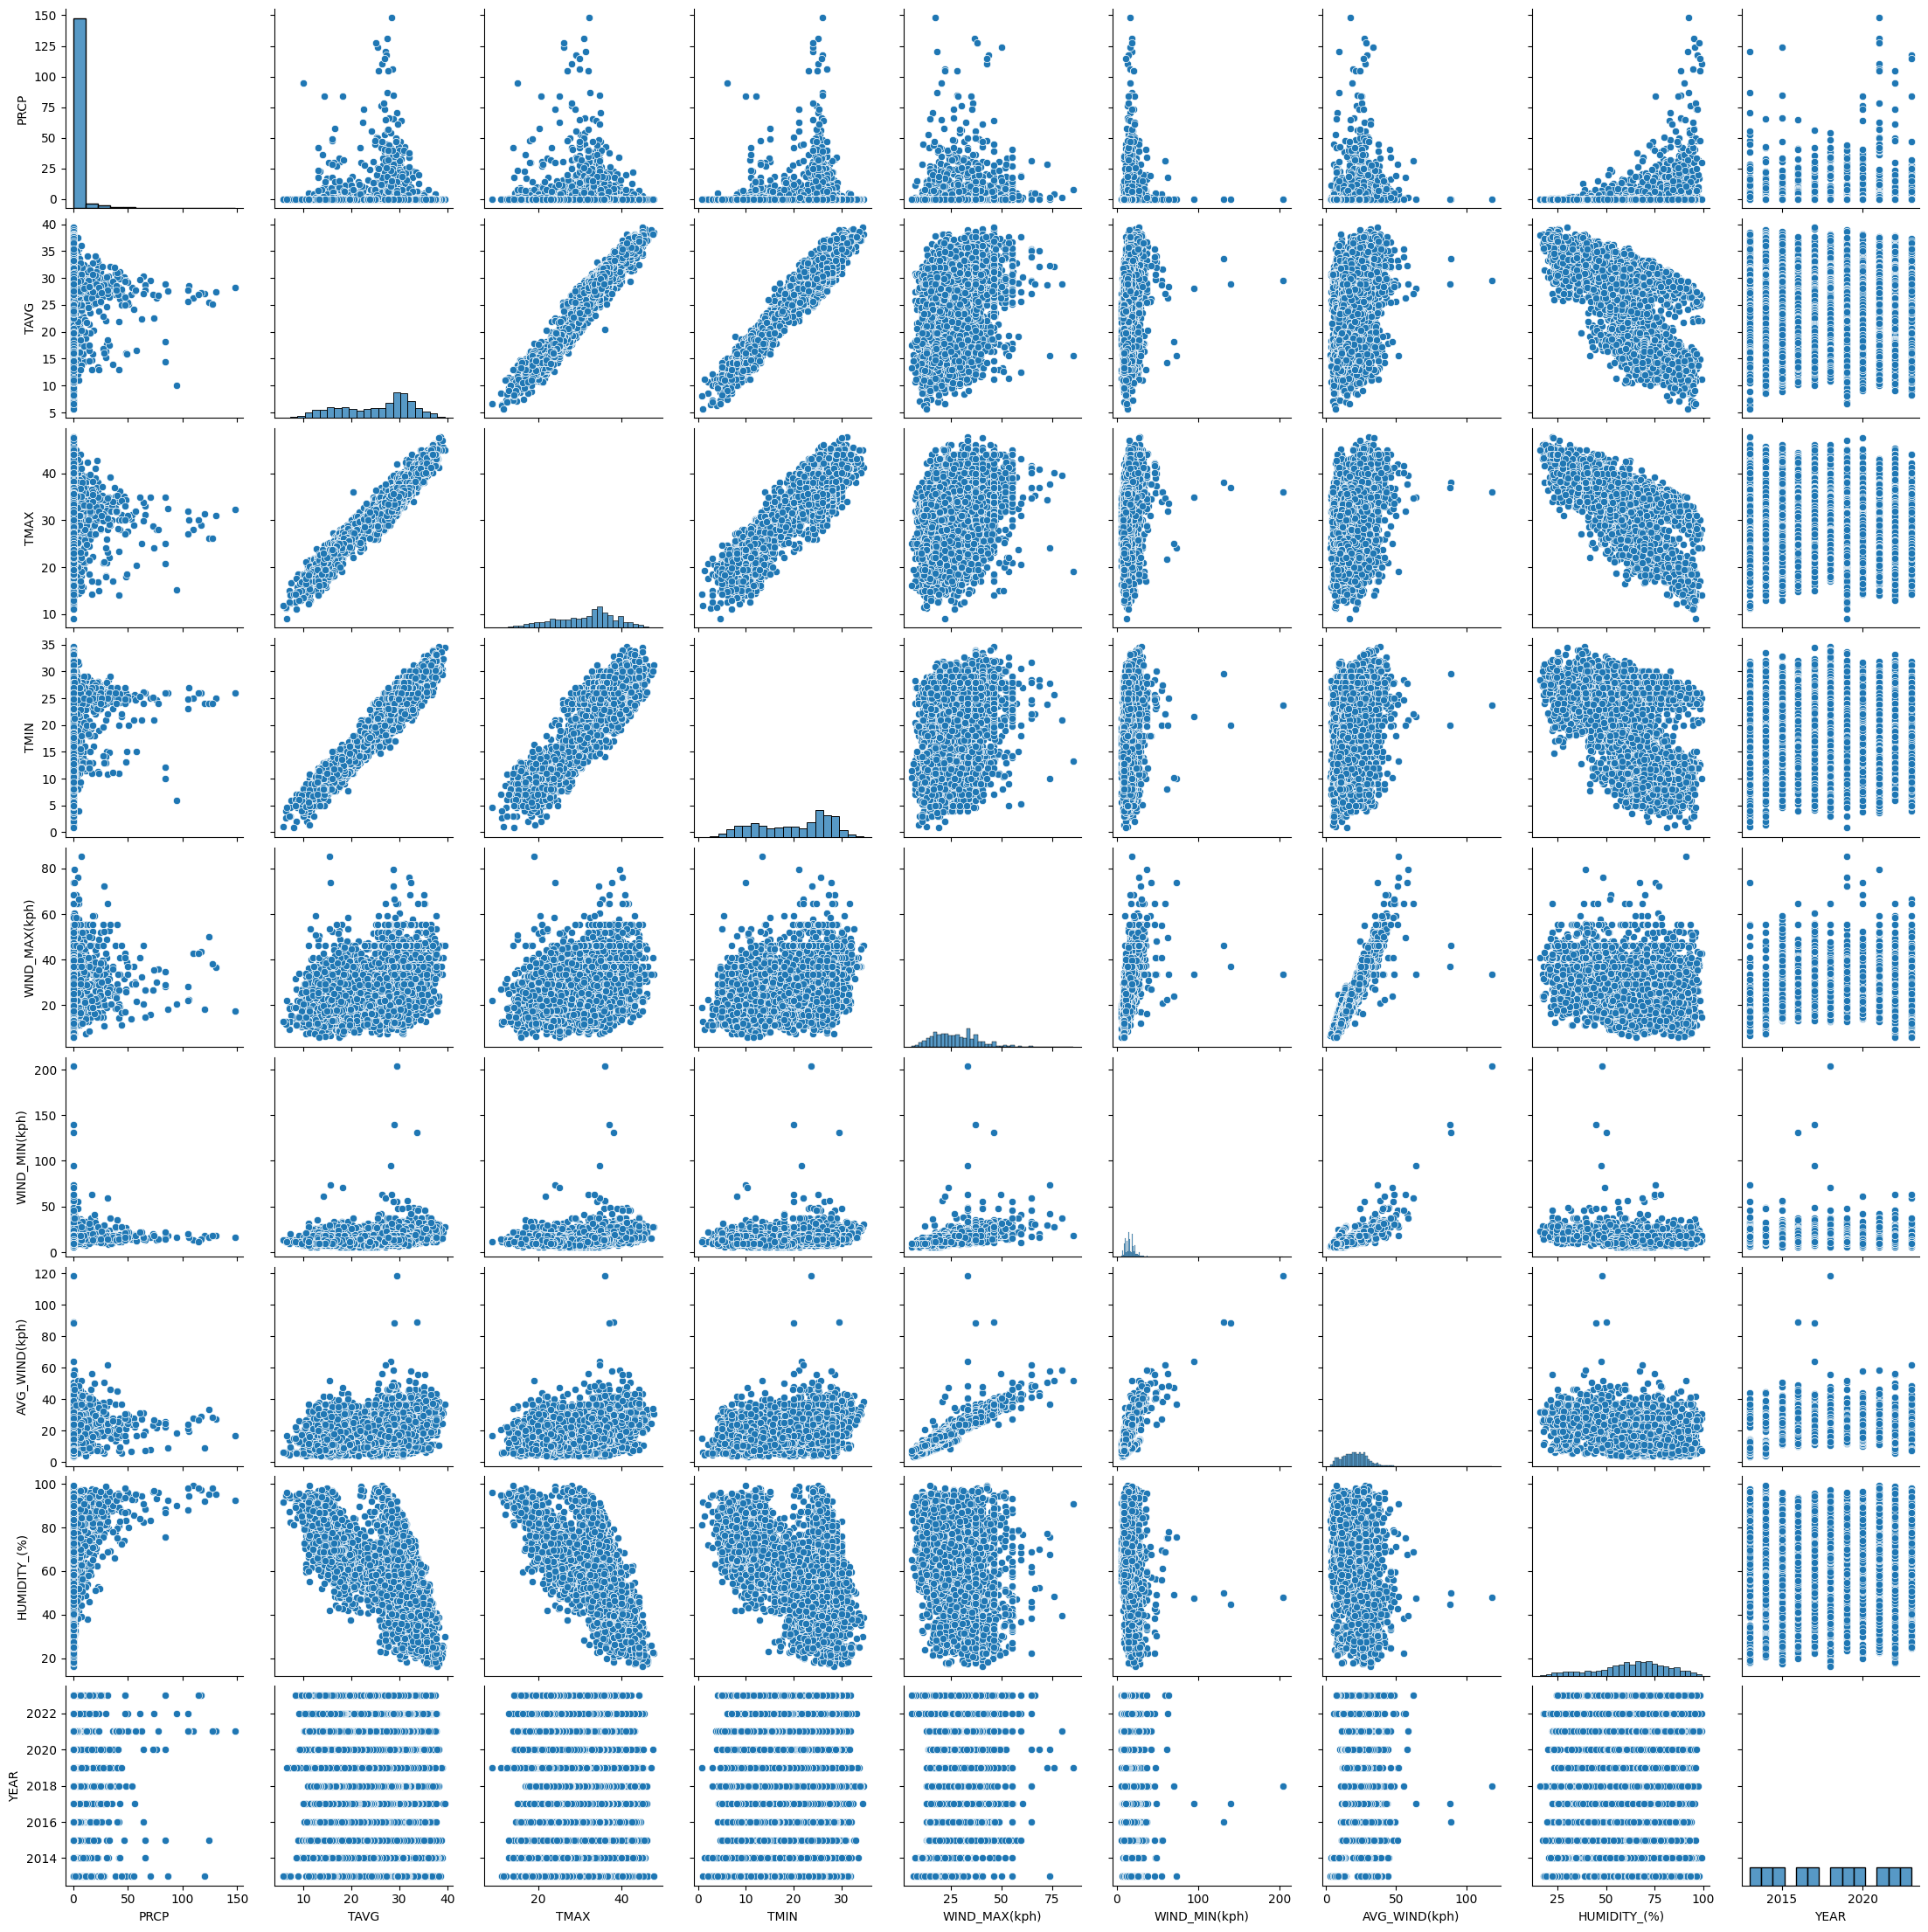

In [24]:
sns.pairplot(df)

#### **Co - Relation matrix**

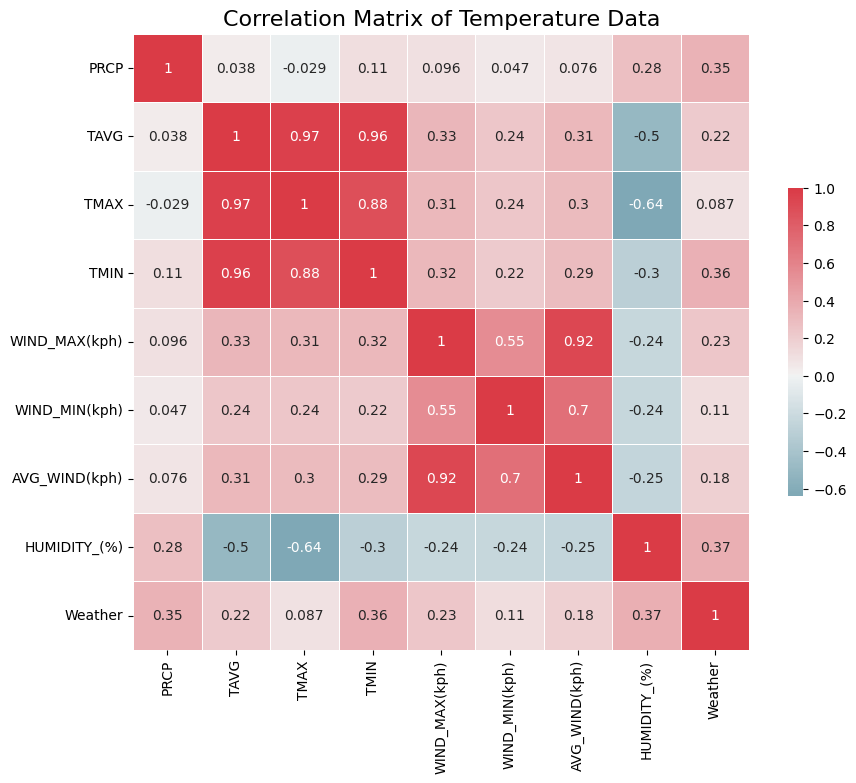

In [25]:
# Transforming Weather string data labels into numerical labels
le = LabelEncoder()
df_imputed['Weather'] = le.fit_transform(df_imputed['Weather'])

# Compute correlation matrix
corr = df_imputed.corr()

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10,8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.title('Correlation Matrix of Temperature Data', fontsize=16)
plt.show()


<h3><b>Inferences from Co-Relation Matrix and Pair Plot</b></h3>
<p>The following inferences can be made from the correlation matrix and pair plot of the given data frame:</p>
<ul>
<li>The maximum and minimum temperature variables have a strong positive correlation, which is expected given that they both represent temperature measurements.</li>
<li>There is a moderate positive correlation between average wind speed and wind maximum, as well as between average wind speed and wind minimum. This suggests that wind tends to be consistent across different measures.</li>
<li>There is no clear correlation between precipitation and any of the other variables, which is expected given that precipitation is a separate weather variable.</li>
<li>Temperature variables (TAVG, TMAX, TMIN) are all strongly correlated with each other, which is expected given that they are different measures of temperature.</li>
<li>There does not appear to be a strong relationship between any of the weather variables and year, which suggests that these variables are not strongly influenced by time.</li>
</ul>

In [26]:
# creating a copy of the dataframe so that the original data isn't tampered with
df_rev = df_imputed.copy()

In [27]:
# Using Mannual encoding for the weather column since it is categorical

# Check if 'Weather' column exists before replacing values
if 'Weather' in df_rev.columns:
    df_rev["Weather"] = df_rev["Weather"].replace({"Clear":0,"Partially cloudy":1,"Rain, Partially cloudy":2,"Rain, Cloudy":3,"Rain":4, "Cloudy":5})
else:
    print("The 'Weather' column does not exist in the DataFrame.")

In [28]:
# Rename the columns
df_rev = df_rev.rename(columns={"DATE": "DATE", "PRCP": "PRCP", "TAVG": "TAVG", "TMAX": "TMAX",
                        "TMIN": "TMIN", "WIND_MAX(kph)": "WIND_MAX(kph)", "WIND_MIN(kph)": "WIND_MIN(kph)",
                        "AVG_WIND(kph)": "AVG_WIND(kph)", "HUMIDITY_(%)": "HUMIDITY", "Weather": "Weather"})

In [29]:
# Creating the Independent and Dependent variables

X = df_rev.iloc[:,0:-1]
Y = df_rev.iloc[:,-1]

In [30]:
# Checking the created variables

print(X.shape)
print(Y.shape)

(4017, 8)
(4017,)


### **Confirming the Data type of the Dependendent variable**

In [31]:
Y = Y.astype(int)
print(Y)

DATE
2013-01-01    2
2013-01-02    2
2013-01-03    2
2013-01-04    2
2013-01-05    2
             ..
2023-12-27    2
2023-12-28    2
2023-12-29    2
2023-12-30    2
2023-12-31    2
Name: Weather, Length: 4017, dtype: int64


### **Train test split**

In [32]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=10)

In [33]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(3213, 8)
(3213,)
(804, 8)
(804,)


## **Building and evaluating the Different types of Classifier models**

### **Logistic Regression**

Accuracy: 70.02%
Precision: 70.60%
Recall: 70.02%
F1-score: 69.78%

Classification report:
              precision    recall  f1-score   support

           0       0.69      0.78      0.73       325
           2       0.64      0.66      0.65       303
           3       0.00      0.00      0.00         4
           4       0.75      0.33      0.46        18
           5       0.87      0.68      0.76       154

    accuracy                           0.70       804
   macro avg       0.59      0.49      0.52       804
weighted avg       0.71      0.70      0.70       804



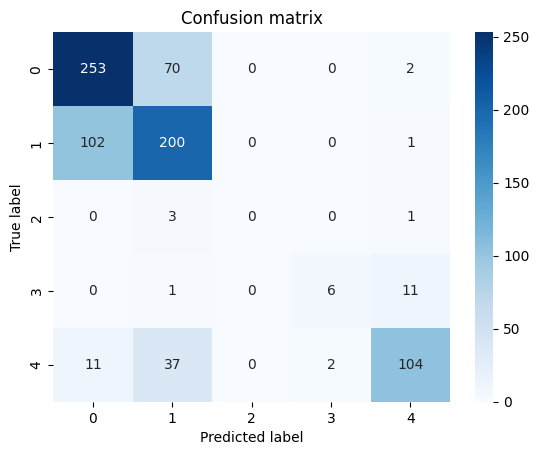

In [34]:
# define the column transformer
ct = ColumnTransformer([
    ('scale', StandardScaler(), ['PRCP', 'TMAX', 'TMIN', 'WIND_MAX(kph)',
       'WIND_MIN(kph)', 'HUMIDITY'])
])

# define the logistic regression model
lr = LogisticRegression()

# create the pipeline
pipe = Pipeline([
    ('transform', ct),
    ('model', lr)
])

# Fit the pipeline on the training data
pipe.fit(X_train, Y_train)

# Predict on the test data
y_pred = pipe.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy*100))

precision = precision_score(Y_test, y_pred, average='weighted')
print('Precision: {:.2f}%'.format(precision*100))

recall = recall_score(Y_test, y_pred, average='weighted')
print('Recall: {:.2f}%'.format(recall*100))

f1 = f1_score(Y_test, y_pred, average='weighted')
print('F1-score: {:.2f}%'.format(f1*100))

print('\nClassification report:')
print(classification_report(Y_test, y_pred))

# Plot confusion matrix as heatmap
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### **KNN Classifier**

Accuracy: 65.42%
Precision: 64.91%
Recall: 65.42%
F1-score: 64.29%

Classification report:
              precision    recall  f1-score   support

           0       0.67      0.84      0.74       325
           2       0.62      0.57      0.59       303
           3       0.00      0.00      0.00         4
           4       0.38      0.17      0.23        18
           5       0.72      0.51      0.60       154

    accuracy                           0.65       804
   macro avg       0.48      0.42      0.43       804
weighted avg       0.65      0.65      0.64       804



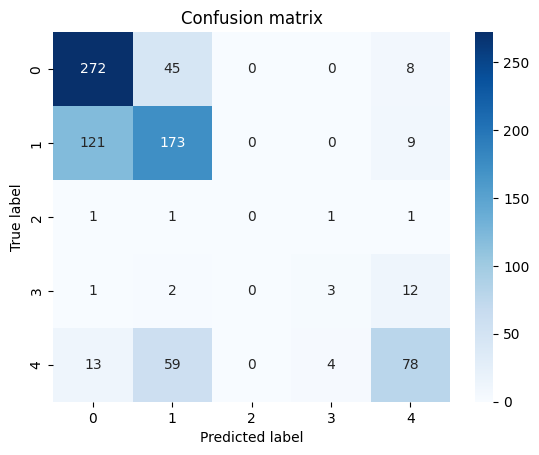

In [35]:
# define the column transformer
ct = ColumnTransformer([
    ('scale', StandardScaler(), ['PRCP', 'TMAX', 'TMIN', 'WIND_MAX(kph)',
       'WIND_MIN(kph)' ]) # Removed 'HUMIDITY'
])


# Defining the knn model
knn= KNeighborsClassifier(n_neighbors=8,metric="euclidean")

# create the pipeline
pipe = Pipeline([
    ('transform', ct),
    ('model', knn)
])

# Fit the pipeline on the training data
pipe.fit(X_train, Y_train)

# Predict on the test data
y_pred = pipe.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy*100))

precision = precision_score(Y_test, y_pred, average='weighted')
print('Precision: {:.2f}%'.format(precision*100))

recall = recall_score(Y_test, y_pred, average='weighted')
print('Recall: {:.2f}%'.format(recall*100))

f1 = f1_score(Y_test, y_pred, average='weighted')
print('F1-score: {:.2f}%'.format(f1*100))

print('\nClassification report:')
print(classification_report(Y_test, y_pred))

# Plot confusion matrix as heatmap
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### **Tuning the model**

In [36]:
"""

my_dict={}
for K in range(1,31):
    model_KNN = KNeighborsClassifier(n_neighbors=K,metric="euclidean")
    model_KNN.fit(X_train, Y_train)
    Y_pred = model_KNN.predict(X_test)
    print ("Accuracy is ", accuracy_score(Y_test,Y_pred), "for K-Value:",K)
    my_dict[K]=accuracy_score(Y_test,Y_pred)

"""

'\n\nmy_dict={}\nfor K in range(1,31):\n    model_KNN = KNeighborsClassifier(n_neighbors=K,metric="euclidean")\n    model_KNN.fit(X_train, Y_train)\n    Y_pred = model_KNN.predict(X_test)\n    print ("Accuracy is ", accuracy_score(Y_test,Y_pred), "for K-Value:",K)\n    my_dict[K]=accuracy_score(Y_test,Y_pred)\n\n'

In [37]:
"""

for k in my_dict:
    if my_dict[k]==max(my_dict.values()):
        print(k,":",my_dict[k])

"""

'\n\nfor k in my_dict:\n    if my_dict[k]==max(my_dict.values()):\n        print(k,":",my_dict[k])\n\n'

### **Decision tree Classifier**

Accuracy: 76.24%
Precision: 77.73%
Recall: 76.24%
F1-score: 75.19%

Classification report:
              precision    recall  f1-score   support

           0       0.68      0.90      0.77       325
           2       0.83      0.55      0.66       303
           3       0.00      0.00      0.00         4
           4       0.70      0.39      0.50        18
           5       0.91      0.97      0.94       154

    accuracy                           0.76       804
   macro avg       0.62      0.56      0.57       804
weighted avg       0.78      0.76      0.75       804



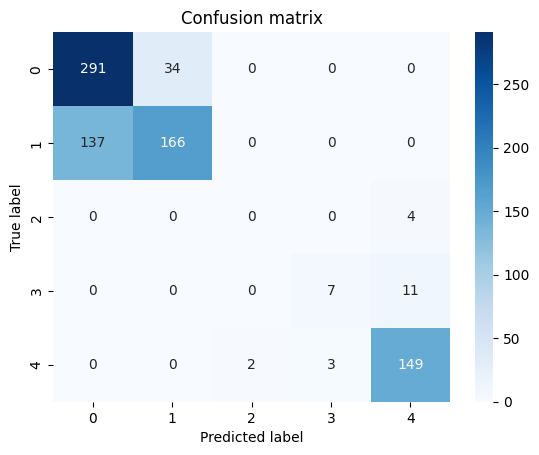

In [38]:
# define the column transformer
ct = ColumnTransformer([
    ('scale', StandardScaler(), ['PRCP', 'TMAX', 'TMIN', 'WIND_MAX(kph)',
       'WIND_MIN(kph)', 'HUMIDITY'])
])

# Defining the knn model
dt = DecisionTreeClassifier(criterion="gini",
                            max_depth=6,
                            min_samples_leaf=2,
                            min_samples_split=6,
                            splitter='best')

# create the pipeline
pipe = Pipeline([
    ('transform', ct),
    ('model', dt)
])

# Fit the pipeline on the training data
pipe.fit(X_train, Y_train)

# Predict on the test data
y_pred = pipe.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy*100))

precision = precision_score(Y_test, y_pred, average='weighted')
print('Precision: {:.2f}%'.format(precision*100))

recall = recall_score(Y_test, y_pred, average='weighted')
print('Recall: {:.2f}%'.format(recall*100))

f1 = f1_score(Y_test, y_pred, average='weighted')
print('F1-score: {:.2f}%'.format(f1*100))

print('\nClassification report:')
print(classification_report(Y_test, y_pred))

# Plot confusion matrix as heatmap
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### **Finding the best parameters**

In [39]:
"""

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 4, 6, 8, 10, 12, 14, 16],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [2, 4, 6, 8],
}

# Create a DecisionTreeClassifier object
dtc = DecisionTreeClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, Y_train)

# Print the best parameters and the corresponding score
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

"""

"\n\n# Define the parameter grid\nparam_grid = {\n    'criterion': ['gini', 'entropy'],\n    'splitter': ['best', 'random'],\n    'max_depth': [None, 4, 6, 8, 10, 12, 14, 16],\n    'min_samples_split': [2, 4, 6, 8, 10],\n    'min_samples_leaf': [2, 4, 6, 8],\n}\n\n# Create a DecisionTreeClassifier object\ndtc = DecisionTreeClassifier()\n\n# Create a GridSearchCV object\ngrid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=5)\n\n# Fit the GridSearchCV object to the data\ngrid_search.fit(X_train, Y_train)\n\n# Print the best parameters and the corresponding score\nprint('Best parameters:', grid_search.best_params_)\nprint('Best score:', grid_search.best_score_)\n\n"

### **XG Boost Classifier**

Accuracy: 76.62%
Precision: 76.86%
Recall: 76.62%
F1-score: 75.75%

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.86      0.77       325
           2       0.80      0.60      0.68       303
           3       0.00      0.00      0.00         4
           4       0.55      0.33      0.41        18
           5       0.90      0.97      0.93       154

    accuracy                           0.77       804
   macro avg       0.59      0.55      0.56       804
weighted avg       0.77      0.77      0.76       804



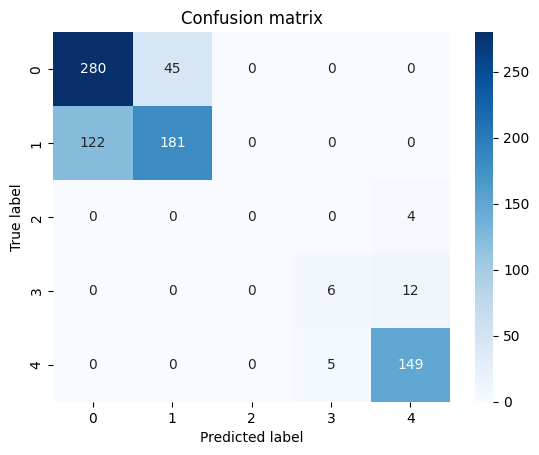

In [40]:
# define the column transformer
ct = ColumnTransformer([
    ('scale', StandardScaler(), ['PRCP',  'TMAX', 'TMIN', 'WIND_MAX(kph)',
       'WIND_MIN(kph)', 'HUMIDITY'])
])

# define the logistic regression model
xgb = xgb.XGBClassifier(n_estimators=100,
                        learning_rate=0.1,
                        max_depth=3,
                        random_state=10)

# create the pipeline
pipe = Pipeline([
    ('transform', ct),
    ('model', xgb)
])

# Fit the pipeline on the training data
pipe.fit(X_train, Y_train)

# Predict on the test data
y_pred = pipe.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy*100))

precision = precision_score(Y_test, y_pred, average='weighted')
print('Precision: {:.2f}%'.format(precision*100))

recall = recall_score(Y_test, y_pred, average='weighted')
print('Recall: {:.2f}%'.format(recall*100))

f1 = f1_score(Y_test, y_pred, average='weighted')
print('F1-score: {:.2f}%'.format(f1*100))

print('\nClassification report:')
print(classification_report(Y_test, y_pred))

# Plot confusion matrix as heatmap
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### **Support Vector Classifier (SVC)**

In [41]:
'''

# define the column transformer
ct = ColumnTransformer([
    ('scale', StandardScaler(), ['PRCP', 'TAVG', 'TMAX', 'TMIN', 'WIND_MAX(kph)',
       'WIND_MIN(kph)', 'AVG_WIND(kph)','HUMIDITY_(%)'])
])

# define the logistic regression model
svc = SVC(kernel='rbf',C=100,gamma=0.01)

# create the pipeline
pipe = Pipeline([
    ('transform', ct),
    ('model', svc)
])

# Fit the pipeline on the training data
pipe.fit(X_train, Y_train)

# Predict on the test data
y_pred = pipe.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy*100))

precision = precision_score(Y_test, y_pred, average='weighted')
print('Precision: {:.2f}%'.format(precision*100))

recall = recall_score(Y_test, y_pred, average='weighted')
print('Recall: {:.2f}%'.format(recall*100))

f1 = f1_score(Y_test, y_pred, average='weighted')
print('F1-score: {:.2f}%'.format(f1*100))

print('\nClassification report:')
print(classification_report(Y_test, y_pred))

# Plot confusion matrix as heatmap
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

'''

"\n\n# define the column transformer\nct = ColumnTransformer([\n    ('scale', StandardScaler(), ['PRCP', 'TAVG', 'TMAX', 'TMIN', 'WIND_MAX(kph)',\n       'WIND_MIN(kph)', 'AVG_WIND(kph)','HUMIDITY_(%)'])\n])\n\n# define the logistic regression model\nsvc = SVC(kernel='rbf',C=100,gamma=0.01)\n\n# create the pipeline\npipe = Pipeline([\n    ('transform', ct),\n    ('model', svc)\n])\n\n# Fit the pipeline on the training data\npipe.fit(X_train, Y_train)\n\n# Predict on the test data\ny_pred = pipe.predict(X_test)\n\n# Evaluate the model\naccuracy = accuracy_score(Y_test, y_pred)\nprint('Accuracy: {:.2f}%'.format(accuracy*100))\n\nprecision = precision_score(Y_test, y_pred, average='weighted')\nprint('Precision: {:.2f}%'.format(precision*100))\n\nrecall = recall_score(Y_test, y_pred, average='weighted')\nprint('Recall: {:.2f}%'.format(recall*100))\n\nf1 = f1_score(Y_test, y_pred, average='weighted')\nprint('F1-score: {:.2f}%'.format(f1*100))\n\nprint('\nClassification report:')\nprint(clas

### **Stacking CLassifier**

Accuracy: 40.42%
Precision: 16.34%
Recall: 40.42%
F1-score: 23.27%

Classification report:
              precision    recall  f1-score   support

           0       0.40      1.00      0.58       325
           2       0.00      0.00      0.00       303
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00       154

    accuracy                           0.40       804
   macro avg       0.08      0.20      0.12       804
weighted avg       0.16      0.40      0.23       804



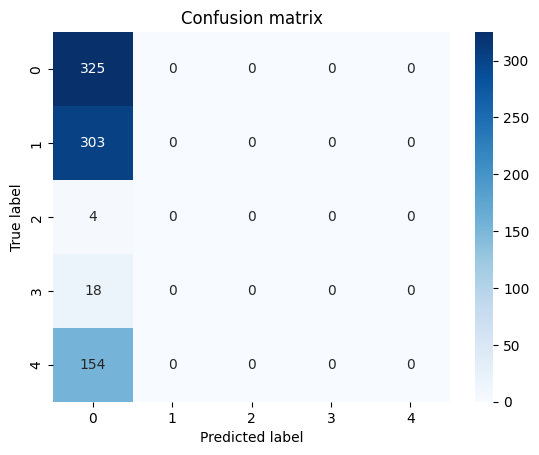

In [42]:
ct = ColumnTransformer([
    ('scale', StandardScaler(), ['PRCP',  'TMAX', 'TMIN', 'WIND_MAX(kph)',
       'WIND_MIN(kph)', 'HUMIDITY'])
])

# define the base regressors
estimators = [
    ('svc', SVC(kernel='rbf', C=100, gamma=0.001)),
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=10,
                                  max_samples=0.7, max_features=0.6, max_depth=14)),
    ('dt', DecisionTreeClassifier(max_depth=8))
]

# define the meta regressor
meta_regressor = LogisticRegression()

# create the stacking regressor
sr = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_regressor
)

# create the pipeline
pipe = Pipeline([
    ('transform', ct),
    ('model', sr)
])

# Fit the pipeline on the training data
pipe.fit(X_train, Y_train)

# Predict on the test data
y_pred = pipe.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy*100))

precision = precision_score(Y_test, y_pred, average='weighted')
print('Precision: {:.2f}%'.format(precision*100))

recall = recall_score(Y_test, y_pred, average='weighted')
print('Recall: {:.2f}%'.format(recall*100))

f1 = f1_score(Y_test, y_pred, average='weighted')
print('F1-score: {:.2f}%'.format(f1*100))

print('\nClassification report:')
print(classification_report(Y_test, y_pred))

# Plot confusion matrix as heatmap
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### **K-Fold Cross valiadation**

In [43]:
"""

# Define the pipeline with logistic regression
pipe = Pipeline([
    ('logistic_regression', RandomForestClassifier(n_estimators=200, random_state=10,
                max_samples=0.9, max_features=0.6, max_depth=14))
])

# Define the KFold cross-validation object
kfold_cv = KFold(n_splits=10, random_state=10, shuffle=True)

# Run the pipeline and obtain the cross-validation scores
kfold_cv_result = cross_val_score(pipe, X_train, Y_train, cv=kfold_cv)

print('K-fold cross-validation scores:', kfold_cv_result)
print('Mean score:', kfold_cv_result.mean())

"""

"\n\n# Define the pipeline with logistic regression\npipe = Pipeline([\n    ('logistic_regression', RandomForestClassifier(n_estimators=200, random_state=10,\n                max_samples=0.9, max_features=0.6, max_depth=14))\n])\n\n# Define the KFold cross-validation object\nkfold_cv = KFold(n_splits=10, random_state=10, shuffle=True)\n\n# Run the pipeline and obtain the cross-validation scores\nkfold_cv_result = cross_val_score(pipe, X_train, Y_train, cv=kfold_cv)\n\nprint('K-fold cross-validation scores:', kfold_cv_result)\nprint('Mean score:', kfold_cv_result.mean())\n\n"

### **Stratified K-Fold validation**

In [44]:
"""

# Define the pipeline with logistic regression
pipe = Pipeline([
    ('logistic_regression', RandomForestClassifier(n_estimators=200, random_state=10,
                max_samples=0.9, max_features=0.6, max_depth=14))
])

# Define the StratifiedKFold cross-validation object
stratified_kfold_cv = StratifiedKFold(n_splits=10, random_state=10, shuffle=True)

# Run the pipeline and obtain the cross-validation scores
stratified_kfold_cv_result = cross_val_score(pipe, X_train, Y_train, cv=stratified_kfold_cv)

print('Stratified K-fold cross-validation scores:', stratified_kfold_cv_result)
print('Mean score:', stratified_kfold_cv_result.mean())

"""

"\n\n# Define the pipeline with logistic regression\npipe = Pipeline([\n    ('logistic_regression', RandomForestClassifier(n_estimators=200, random_state=10,\n                max_samples=0.9, max_features=0.6, max_depth=14))\n])\n\n# Define the StratifiedKFold cross-validation object\nstratified_kfold_cv = StratifiedKFold(n_splits=10, random_state=10, shuffle=True)\n\n# Run the pipeline and obtain the cross-validation scores\nstratified_kfold_cv_result = cross_val_score(pipe, X_train, Y_train, cv=stratified_kfold_cv)\n\nprint('Stratified K-fold cross-validation scores:', stratified_kfold_cv_result)\nprint('Mean score:', stratified_kfold_cv_result.mean())\n\n"

### **Gradient Boosting Classifier**

Accuracy: 75.87%
Precision: 76.09%
Recall: 75.87%
F1-score: 75.56%

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.82      0.76       325
           1       0.00      0.00      0.00         0
           2       0.77      0.64      0.70       303
           3       0.00      0.00      0.00         4
           4       0.46      0.33      0.39        18
           5       0.91      0.93      0.92       154

    accuracy                           0.76       804
   macro avg       0.47      0.45      0.46       804
weighted avg       0.76      0.76      0.76       804



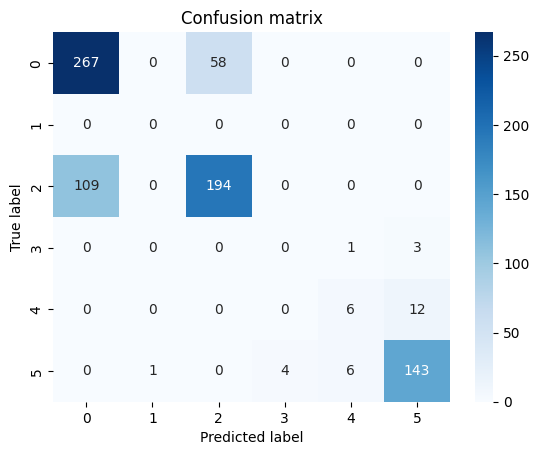

In [45]:
# define the column transformer
ct = ColumnTransformer([
    ('scale', StandardScaler(), ['PRCP', 'TMAX', 'TMIN', 'WIND_MAX(kph)',
       'WIND_MIN(kph)', 'HUMIDITY'])
])

# define the logistic regression model
gbc = GradientBoostingClassifier(n_estimators=100,
                                learning_rate=0.1, max_depth=5,
                                random_state=10,
                                loss='deviance')

# create the pipeline
pipe = Pipeline([
    ('transform', ct),
    ('model', gbc)
])

# Fit the pipeline on the training data
pipe.fit(X_train, Y_train)

# Predict on the test data
y_pred = pipe.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy*100))

precision = precision_score(Y_test, y_pred, average='weighted')
print('Precision: {:.2f}%'.format(precision*100))

recall = recall_score(Y_test, y_pred, average='weighted')
print('Recall: {:.2f}%'.format(recall*100))

f1 = f1_score(Y_test, y_pred, average='weighted')
print('F1-score: {:.2f}%'.format(f1*100))

print('\nClassification report:')
print(classification_report(Y_test, y_pred))

# Plot confusion matrix as heatmap
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### **Finding the best parameters**

In [46]:
"""

# Define the parameter grid
param_grid = {
    'n_estimators': [ 100, 200],
    'learning_rate': [0.01, 0.1,],
    'max_depth': [5, 7, 9],
    'loss': ['deviance', 'exponential'],
}

# Create a GradientBoostingClassifier object
gbc = GradientBoostingClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, Y_train)

# Print the best parameters and the corresponding score
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

"""

"\n\n# Define the parameter grid\nparam_grid = {\n    'n_estimators': [ 100, 200],\n    'learning_rate': [0.01, 0.1,],\n    'max_depth': [5, 7, 9],\n    'loss': ['deviance', 'exponential'],\n}\n\n# Create a GradientBoostingClassifier object\ngbc = GradientBoostingClassifier()\n\n# Create a GridSearchCV object\ngrid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=5)\n\n# Fit the GridSearchCV object to the data\ngrid_search.fit(X_train, Y_train)\n\n# Print the best parameters and the corresponding score\nprint('Best parameters:', grid_search.best_params_)\nprint('Best score:', grid_search.best_score_)\n\n"

### **Random Forest Classifier**

Accuracy: 76.00%
Precision: 75.56%
Recall: 76.00%
F1-score: 75.42%

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.81      0.75       325
           2       0.76      0.64      0.69       303
           3       0.00      0.00      0.00         4
           4       0.46      0.33      0.39        18
           5       0.91      0.96      0.93       154

    accuracy                           0.76       804
   macro avg       0.57      0.55      0.55       804
weighted avg       0.76      0.76      0.75       804



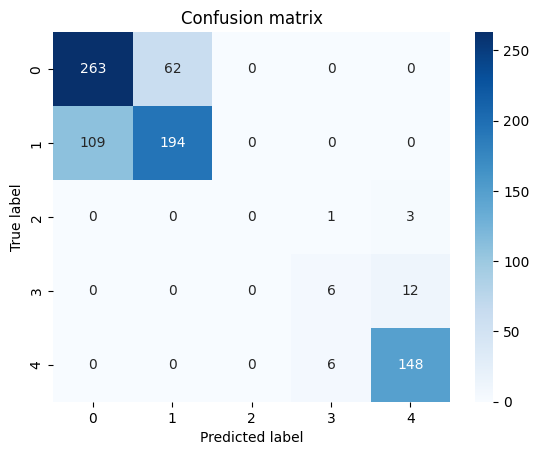

In [47]:
# define the column transformer
ct = ColumnTransformer([
    ('scale', StandardScaler(), ['PRCP', 'TMAX', 'TMIN', 'WIND_MAX(kph)',
       'WIND_MIN(kph)', 'HUMIDITY'])
])

# define the Random Forest regressor model
rf = RandomForestClassifier(n_estimators=200,
                            random_state=10,
                            max_samples=0.9,
                            max_features=0.6,
                            max_depth=14)

# create the pipeline
pipe = Pipeline([
    ('transform', ct),
    ('model', rf)
])

# Fit the pipeline on the training data
pipe.fit(X_train, Y_train)

# Predict on the test data
y_pred = pipe.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy*100))

precision = precision_score(Y_test, y_pred, average='weighted')
print('Precision: {:.2f}%'.format(precision*100))

recall = recall_score(Y_test, y_pred, average='weighted')
print('Recall: {:.2f}%'.format(recall*100))

f1 = f1_score(Y_test, y_pred, average='weighted')
print('F1-score: {:.2f}%'.format(f1*100))

print('\nClassification report:')
print(classification_report(Y_test, y_pred))

# Plot confusion matrix as heatmap
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### **Finding the best parameters**

In [48]:
"""

# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 0.5, 0.6, 0.7, 0.9],
    'max_depth': [3, 5, 7, 9, 11, 14],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create a RandomForestClassifier object
rfc = RandomForestClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, Y_train)

# Print the best parameters and the corresponding score
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

"""

"\n\n# Import necessary libraries\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import GridSearchCV\n\n# Define the parameter grid\nparam_grid = {\n    'n_estimators': [50, 100, 200],\n    'max_features': ['auto', 0.5, 0.6, 0.7, 0.9],\n    'max_depth': [3, 5, 7, 9, 11, 14],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4],\n}\n\n# Create a RandomForestClassifier object\nrfc = RandomForestClassifier()\n\n# Create a GridSearchCV object\ngrid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)\n\n# Fit the GridSearchCV object to the data\ngrid_search.fit(X_train, Y_train)\n\n# Print the best parameters and the corresponding score\nprint('Best parameters:', grid_search.best_params_)\nprint('Best score:', grid_search.best_score_)\n\n"

### **Tabulating the Results**

In [49]:
data = {
    'Model': ['Logistic Regression', 'KNN Classifier', 'Decision Tree Classifier', 'XGBoost Classifier', 'Stacking Classifier', 'Gradient Boosting Classifier', 'Random Forest Classifier'],
    'Accuracy': ['70.02%' , '65.42%', '76.24%','76.62%', '40.42%', '75.87%', '76.00%'],
    'Precision': ['70.60%', '64.91%', '77.66%','76.86%', '16.34%', '76.09%' , '75.56%'],
    'Recall': ['70.02%', '65.42%', '76.24%', '76.62%', '40.42%', '75.87%' , '76.00%'],
    'F1-score': ['69.78%', '64.29%', '75.06%', '75.75%', '23.27%', '75.56%', '75.42%']
}

df = pd.DataFrame(data)
df

,Model,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,70.02%,70.60%,70.02%,69.78%
1,KNN Classifier,65.42%,64.91%,65.42%,64.29%
2,Decision Tree Classifier,76.24%,77.66%,76.24%,75.06%
3,XGBoost Classifier,76.62%,76.86%,76.62%,75.75%
4,Stacking Classifier,40.42%,16.34%,40.42%,23.27%
5,Gradient Boosting Classifier,75.87%,76.09%,75.87%,75.56%
6,Random Forest Classifier,76.00%,75.56%,76.00%,75.42%


In [50]:
# Exporting the model and the dataframe for building a Flask app

import pickle

pickle.dump(df_rev,open('df_rev.pkl','wb'))
pickle.dump(pipe,open('pipe.pkl','wb'))

In [51]:
df_rev

,PRCP,TAVG,TMAX,TMIN,WIND_MAX(kph),WIND_MIN(kph),AVG_WIND(kph),HUMIDITY,Weather
DATE,,,,,,,,,
2013-01-01,0.0,8.9,18.5,5.0,11.9,11.9,5.95,90.3,2
2013-01-02,0.0,7.4,16.6,6.0,15.5,15.5,7.75,93.9,2
2013-01-03,0.0,7.3,12.3,4.6,13.0,13.0,6.50,93.8,2
2013-01-04,0.0,7.1,14.9,3.0,9.6,9.6,4.80,87.3,2
2013-01-05,0.0,6.4,11.3,2.6,13.0,13.0,6.50,93.9,2
...,...,...,...,...,...,...,...,...,...
2023-12-27,0.0,13.0,19.5,10.3,11.2,9.4,10.30,91.9,2
2023-12-28,0.0,12.8,19.5,9.3,12.2,9.4,10.80,91.1,2
2023-12-29,0.0,13.8,18.6,12.0,7.9,9.4,8.65,93.9,2


### **Giving a sample input for predictions**

In [52]:
import pandas as pd

# create a sample input
input_data = [[0.59, 31.08, 26.07, 12.68, 12.0, 92.19],
              [0.03, 30.56, 26.67, 14.00, 11.8, 90.61],
              [0.00, 31.10, 26.04, 10.98, 6.0, 85.72],
              [0.00, 11.14, 3.9, 11.9, 11.9, 95]]

# create a DataFrame with the same columns as the training data
input_df = pd.DataFrame(input_data, columns=['PRCP', 'TMAX', 'TMIN', 'WIND_MAX(kph)', 'WIND_MIN(kph)', 'HUMIDITY'])

# make predictions using the pipe object
y_pred = pipe.predict(input_df)

print(y_pred)

[5 5 2 0]


# **The predictions made for the sample inputs are:**   
***"Cloudy", "Cloudy", "Rain, Partially cloudy", "Clear".***